In [3]:
import time
import torch
import pandas as pd
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

print("Bibliothèques importées avec succès.")

c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Bibliothèques importées avec succès.


In [4]:
# Liste des modèles à comparer
# J'ai ajouté le modèle juridique en premier pour qu'il soit notre référence.
models_to_benchmark = [
    # --- Modèles spécialisés ou très performants en multilingue ---
    "NLP-Lisbon/legal-camembert-base-v2", # Le modèle juridique que nous voulons tester
    "BAAI/bge-m3",
    "intfloat/multilingual-e5-base",
    "intfloat/multilingual-e5-small",
    "VAGOsolutions/ChoucrouteLM-Reason-EuroColBERT", # Modèle français
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    "Alibaba-NLP/gte-multilingual-base",
    
    # --- Modèle de base pour comparaison ---
    "dangvantuan/sentence-camembert-base", # Votre ancien modèle
]

print(f"{len(models_to_benchmark)} modèles sélectionnés pour le benchmark.")

9 modèles sélectionnés pour le benchmark.


In [5]:
# Corpus de phrases juridiques françaises
sentences = [
    # Thème 1 : Droit Administratif - Marchés Publics (Label 0)
    "La procédure d'appel d'offres doit respecter les principes de transparence.",
    "Le pouvoir adjudicateur a publié l'avis de marché au journal officiel.",
    "La commission d'appel d'offres examine la validité des candidatures soumises.",
    "L'attribution du marché public sera notifiée au soumissionnaire retenu.",

    # Thème 2 : Droit Pénal (Label 1)
    "L'auteur de l'infraction encourt une peine d'emprisonnement.",
    "Le prévenu a été condamné à une amende pour vol simple.",
    "La garde à vue ne peut excéder une durée de vingt-quatre heures.",
    "Le code pénal définit les crimes, les délits et les contraventions.",

    # Thème 3 : Droit Civil - Famille (Label 2)
    "Le divorce par consentement mutuel requiert l'accord des deux époux.",
    "L'autorité parentale est exercée conjointement par les deux parents.",
    "La filiation est légalement établie par l'acte de naissance.",
    "Le juge aux affaires familiales statue sur la résidence des enfants.",
    
    # Bruit / Outliers (Label -1 pour le score Silhouette)
    "Le parlement a voté une nouvelle loi sur l'environnement.",
    "Les conditions générales de vente sont annexées au contrat."
]

# Labels correspondant aux thèmes pour l'évaluation
# 0: Admin, 1: Pénal, 2: Civil, -1: Bruit
labels = np.array([
    0, 0, 0, 0,
    1, 1, 1, 1,
    2, 2, 2, 2,
    -1, -1
])

print(f"Corpus de test créé avec {len(sentences)} phrases.")

Corpus de test créé avec 14 phrases.


In [6]:
results = []

for model_id in models_to_benchmark:
    print(f"\n--- Benchmark du modèle : {model_id} ---")
    try:
        # Charger le modèle
        start_load_time = time.time()
        model = SentenceTransformer(model_id)
        load_duration = time.time() - start_load_time
        print(f"Modèle chargé en {load_duration:.2f}s.")

        # Vectoriser le corpus
        start_encode_time = time.time()
        embeddings = model.encode(sentences, convert_to_tensor=True)
        encode_duration = time.time() - start_encode_time
        print(f"Corpus vectorisé en {encode_duration:.2f}s.")

        # Obtenir la dimension des vecteurs
        dimension = embeddings.shape[1]

        # Évaluer la qualité du clustering avec le score Silhouette
        # On ne prend que les points qui ne sont pas du bruit
        core_samples_mask = labels != -1
        core_embeddings = embeddings.cpu().numpy()[core_samples_mask]
        core_labels = labels[core_samples_mask]
        
        silhouette = -1 # Score par défaut
        if len(set(core_labels)) > 1:
            silhouette = silhouette_score(core_embeddings, core_labels)
            print(f"Score de similarité (Silhouette) : {silhouette:.4f}")
        else:
            print("Pas assez de clusters pour calculer le score Silhouette.")
            
        # Stocker les résultats
        results.append({
            "modèle": model_id,
            "score_silhouette": silhouette,
            "temps_encodage_s": encode_duration,
            "dimension": dimension,
            "temps_chargement_s": load_duration
        })

        # Libérer la mémoire
        del model
        del embeddings
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"ERREUR lors du traitement du modèle {model_id}: {e}")
        results.append({
            "modèle": model_id,
            "score_silhouette": -1,
            "temps_encodage_s": -1,
            "dimension": -1,
            "temps_chargement_s": -1
        })

print("\n--- Benchmark terminé ! ---")


--- Benchmark du modèle : NLP-Lisbon/legal-camembert-base-v2 ---


No sentence-transformers model found with name NLP-Lisbon/legal-camembert-base-v2. Creating a new one with mean pooling.


ERREUR lors du traitement du modèle NLP-Lisbon/legal-camembert-base-v2: NLP-Lisbon/legal-camembert-base-v2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

--- Benchmark du modèle : BAAI/bge-m3 ---


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--BAAI--bge-m3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle chargé en 75.03s.
Corpus vectorisé en 1.85s.
Score de similarité (Silhouette) : 0.1145

--- Benchmark du modèle : intfloat/multilingual-e5-base ---


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--intfloat--multilingual-e5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle chargé en 46.00s.
Corpus vectorisé en 0.46s.
Score de similarité (Silhouette) : 0.1105

--- Benchmark du modèle : intfloat/multilingual-e5-small ---


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--intfloat--multilingual-e5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle chargé en 20.44s.


No sentence-transformers model found with name VAGOsolutions/ChoucrouteLM-Reason-EuroColBERT. Creating a new one with mean pooling.


Corpus vectorisé en 0.24s.
Score de similarité (Silhouette) : 0.0794

--- Benchmark du modèle : VAGOsolutions/ChoucrouteLM-Reason-EuroColBERT ---
ERREUR lors du traitement du modèle VAGOsolutions/ChoucrouteLM-Reason-EuroColBERT: VAGOsolutions/ChoucrouteLM-Reason-EuroColBERT is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

--- Benchmark du modèle : sentence-transformers/paraphrase-multilingual-mpnet-base-v2 ---


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle chargé en 49.67s.
Corpus vectorisé en 0.56s.
Score de similarité (Silhouette) : 0.1972

--- Benchmark du modèle : sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 ---
Modèle chargé en 4.35s.
Corpus vectorisé en 0.39s.
Score de similarité (Silhouette) : 0.1275

--- Benchmark du modèle : Alibaba-NLP/gte-multilingual-base ---


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--Alibaba-NLP--gte-multilingual-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ERREUR lors du traitement du modèle Alibaba-NLP/gte-multilingual-base: The repository `Alibaba-NLP/gte-multilingual-base` contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/Alibaba-NLP/gte-multilingual-base.
Please pass the argument `trust_remote_code=True` to allow custom code to be run.

--- Benchmark du modèle : dangvantuan/sentence-camembert-base ---


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--dangvantuan--sentence-camembert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle chargé en 14.93s.
Corpus vectorisé en 0.49s.
Score de similarité (Silhouette) : 0.1929

--- Benchmark terminé ! ---


In [7]:
# Convertir les résultats en DataFrame Pandas pour une analyse facile
df_results = pd.DataFrame(results)

# Trier les modèles par le meilleur score de similarité
df_sorted = df_results.sort_values(by="score_silhouette", ascending=False).reset_index(drop=True)

print("Classement des modèles par qualité de clustering (Score Silhouette) :")
display(df_sorted)

Classement des modèles par qualité de clustering (Score Silhouette) :


,modèle,score_silhouette,temps_encodage_s,dimension,temps_chargement_s
0,sentence-transformers/paraphrase-multilingual-...,0.197195,0.561610,768,49.667863
1,dangvantuan/sentence-camembert-base,0.192890,0.486738,768,14.934704
2,sentence-transformers/paraphrase-multilingual-...,0.127488,0.392984,384,4.351798
3,BAAI/bge-m3,0.114510,1.846238,1024,75.028014
4,intfloat/multilingual-e5-base,0.110466,0.464756,768,46.002393
5,intfloat/multilingual-e5-small,0.079400,0.238351,384,20.440799
6,NLP-Lisbon/legal-camembert-base-v2,-1.000000,-1.000000,-1,-1.000000
7,VAGOsolutions/ChoucrouteLM-Reason-EuroColBERT,-1.000000,-1.000000,-1,-1.000000
8,Alibaba-NLP/gte-multilingual-base,-1.000000,-1.000000,-1,-1.000000


C:\Users\naouf\AppData\Local\Temp\ipykernel_21084\1275644697.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='score_silhouette', y='modèle', data=df_sorted, palette='viridis')
C:\Users\naouf\AppData\Local\Temp\ipykernel_21084\1275644697.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='temps_encodage_s', y='modèle', data=df_sorted, palette='plasma')


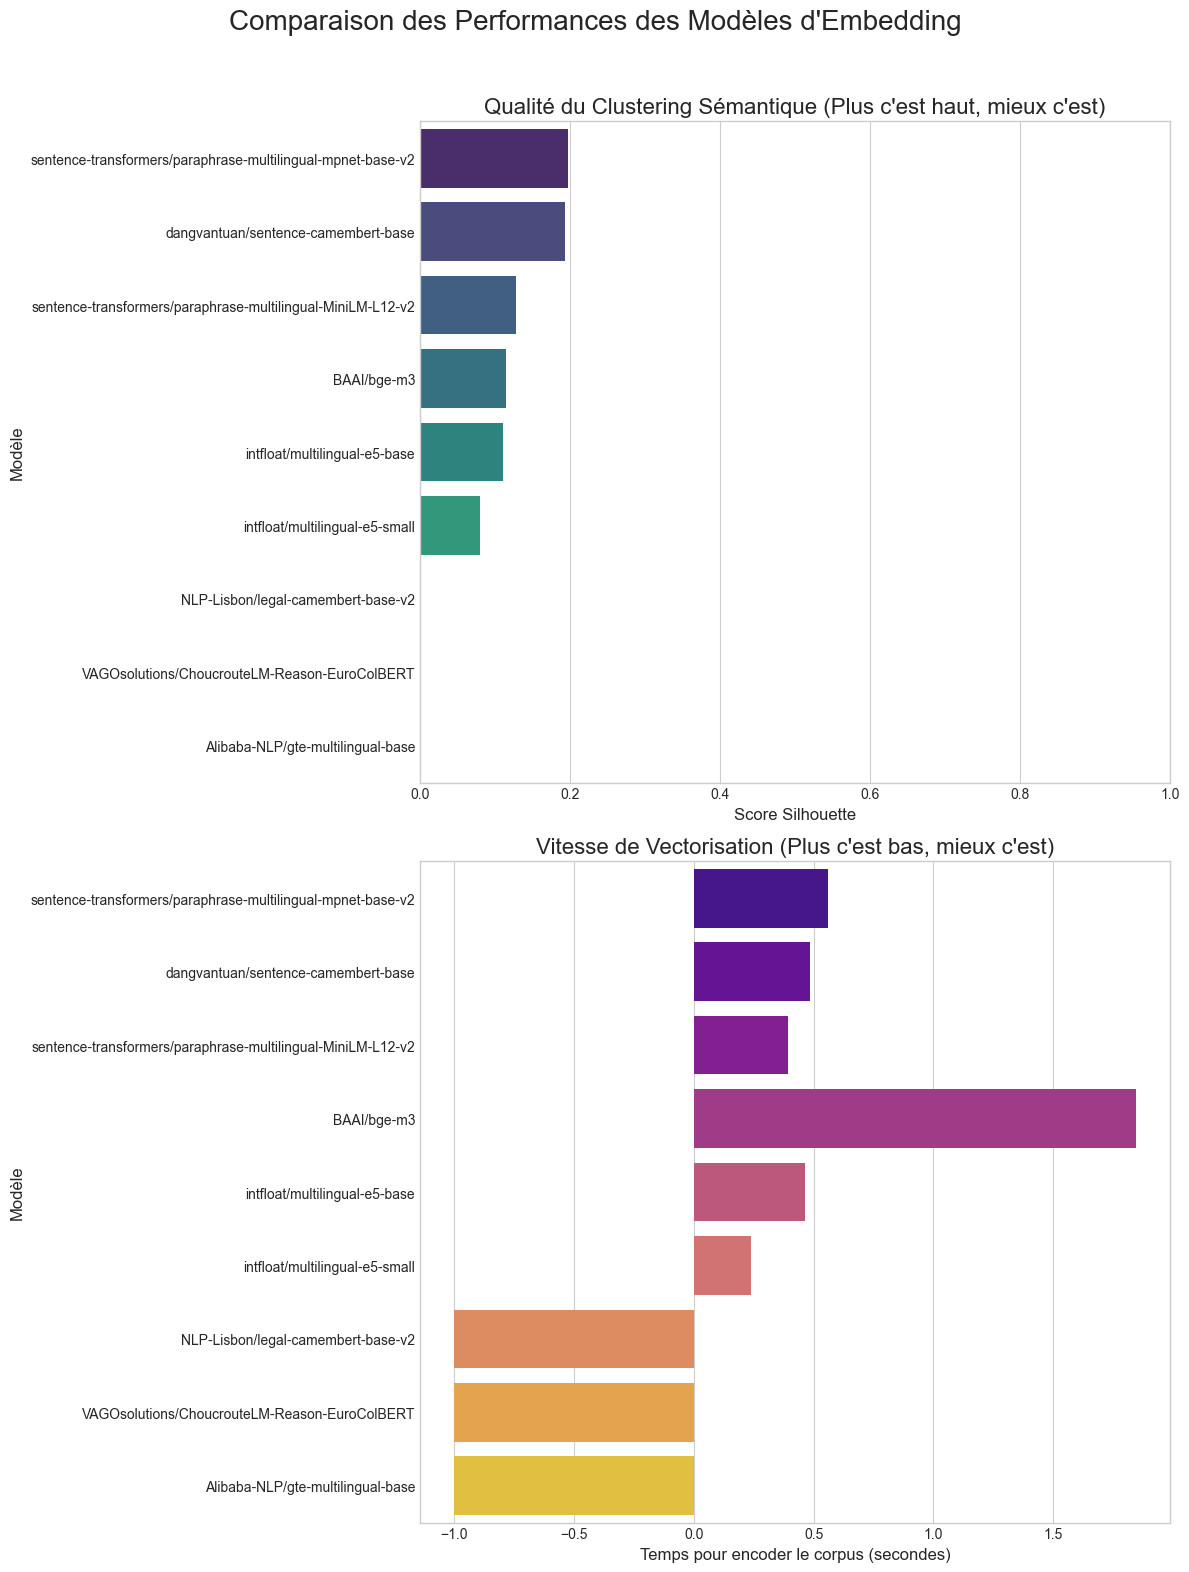

In [8]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
fig.suptitle('Comparaison des Performances des Modèles d\'Embedding', fontsize=20)

# Graphique 1 : Score Silhouette
sns.barplot(ax=axes[0], x='score_silhouette', y='modèle', data=df_sorted, palette='viridis')
axes[0].set_title('Qualité du Clustering Sémantique (Plus c\'est haut, mieux c\'est)', fontsize=16)
axes[0].set_xlabel('Score Silhouette', fontsize=12)
axes[0].set_ylabel('Modèle', fontsize=12)
axes[0].set_xlim([0, 1]) # Le score Silhouette va de -1 à 1

# Graphique 2 : Vitesse d'encodage
sns.barplot(ax=axes[1], x='temps_encodage_s', y='modèle', data=df_sorted, palette='plasma')
axes[1].set_title('Vitesse de Vectorisation (Plus c\'est bas, mieux c\'est)', fontsize=16)
axes[1].set_xlabel('Temps pour encoder le corpus (secondes)', fontsize=12)
axes[1].set_ylabel('Modèle', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Visualisation de l'espace d'embedding du meilleur modèle : sentence-transformers/paraphrase-multilingual-mpnet-base-v2


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


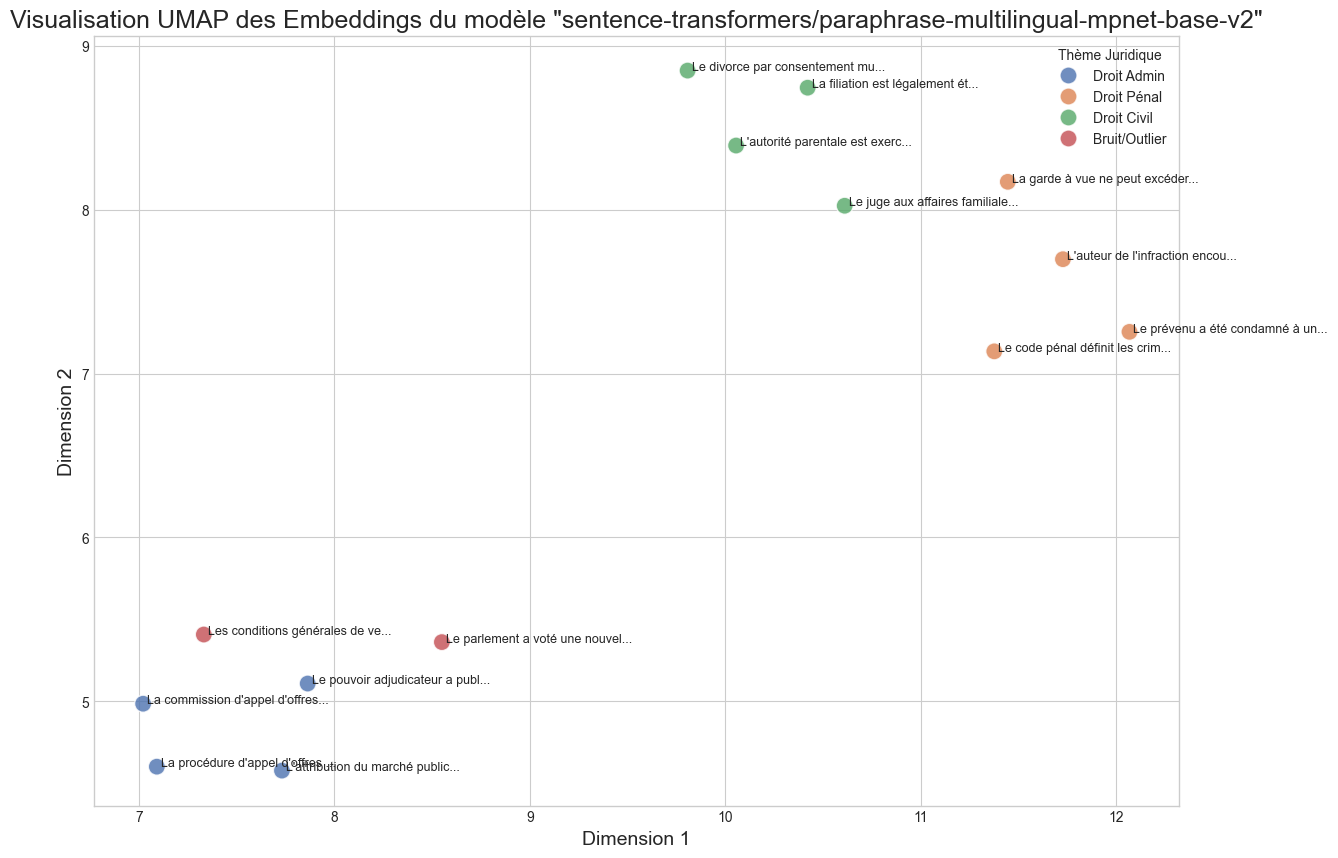

In [9]:
# Sélectionner le meilleur modèle
best_model_id = df_sorted.iloc[0]['modèle']
print(f"Visualisation de l'espace d'embedding du meilleur modèle : {best_model_id}")

# Recharger le meilleur modèle et générer les embeddings
best_model = SentenceTransformer(best_model_id)
all_embeddings = best_model.encode(sentences)

# Réduire la dimensionnalité avec UMAP
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
embeddings_2d = reducer.fit_transform(all_embeddings)

# Créer un DataFrame pour le plotting
df_plot = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_plot['thème'] = [
    'Droit Admin', 'Droit Admin', 'Droit Admin', 'Droit Admin',
    'Droit Pénal', 'Droit Pénal', 'Droit Pénal', 'Droit Pénal',
    'Droit Civil', 'Droit Civil', 'Droit Civil', 'Droit Civil',
    'Bruit/Outlier', 'Bruit/Outlier'
]

# Visualiser
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_plot,
    x='x',
    y='y',
    hue='thème',
    palette='deep',
    s=150,
    alpha=0.8
)

# Annoter chaque point avec un bout de la phrase
for i, sentence in enumerate(sentences):
    plt.text(df_plot.x[i]+0.02, df_plot.y[i], sentence[:30]+"...", fontsize=9)

plt.title(f'Visualisation UMAP des Embeddings du modèle "{best_model_id}"', fontsize=18)
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.legend(title='Thème Juridique')
plt.grid(True)
plt.show()

In [10]:
from sentence_transformers import SentenceTransformer, util
import torch

# --- 1. Configuration ---
# Utiliser le modèle "large" pour la meilleure performance
model_id = "OrdalieTech/Solon-embeddings-large-0.1"

print(f"Chargement du modèle '{model_id}'...")
# SentenceTransformer s'occupe du téléchargement et du chargement
try:
    model = SentenceTransformer(model_id)
    print("Modèle chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")
    exit()

# --- 2. Données de test ---
# Des "passages" qui pourraient être stockés dans votre base de données vectorielle (Qdrant)
passages = [
    "Le délai de prescription pour les actions civiles est de cinq ans.",
    "L'autorité parentale est un ensemble de droits et de devoirs ayant pour finalité l'intérêt de l'enfant.",
    "Toute personne a droit au respect de sa vie privée.",
    "Le pouvoir adjudicateur doit garantir une procédure d'appel d'offres transparente et non discriminatoire."
]

# Des "queries" qui représentent les questions des utilisateurs
queries = [
    "comment protéger ma vie personnelle ?",
    "combien de temps pour une poursuite en justice ?",
    "quelles sont les règles pour les marchés publics ?"
]

# --- 3. Vectorisation (l'étape clé) ---
print("\nVectorisation des passages (sans préfixe)...")
passage_embeddings = model.encode(passages, convert_to_tensor=True)

print("Vectorisation des questions (avec le préfixe 'query:')...")
prefixed_queries = ["query: " + q for q in queries]
query_embeddings = model.encode(prefixed_queries, convert_to_tensor=True)

print("\n--- 4. Calcul de la Similarité ---")
# Utilise la similarité cosinus pour trouver les correspondances
# Le résultat est une matrice où chaque ligne correspond à une query
# et chaque colonne à un passage.
cosine_scores = util.cos_sim(query_embeddings, passage_embeddings)

# --- 5. Affichage des résultats ---
# Pour chaque question, on trouve le passage le plus similaire
for i, query in enumerate(queries):
    # Trouver l'index du score le plus élevé pour la query i
    best_match_idx = torch.argmax(cosine_scores[i]).item()
    best_score = cosine_scores[i][best_match_idx].item()
    
    print(f"\n❓ Question : '{query}'")
    print(f"✅ Meilleure correspondance : '{passages[best_match_idx]}'")
    print(f"   (Score de similarité : {best_score:.4f})")

Chargement du modèle 'OrdalieTech/Solon-embeddings-large-0.1'...


c:\Users\naouf\Documents\1-Naoufel\1-projet\Projet_Fin_Dannée_E3\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\naouf\.cache\huggingface\hub\models--OrdalieTech--Solon-embeddings-large-0.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle chargé avec succès.

Vectorisation des passages (sans préfixe)...
Vectorisation des questions (avec le préfixe 'query:')...

--- 4. Calcul de la Similarité ---

❓ Question : 'comment protéger ma vie personnelle ?'
✅ Meilleure correspondance : 'Toute personne a droit au respect de sa vie privée.'
   (Score de similarité : 0.5147)

❓ Question : 'combien de temps pour une poursuite en justice ?'
✅ Meilleure correspondance : 'Le délai de prescription pour les actions civiles est de cinq ans.'
   (Score de similarité : 0.4672)

❓ Question : 'quelles sont les règles pour les marchés publics ?'
✅ Meilleure correspondance : 'Le pouvoir adjudicateur doit garantir une procédure d'appel d'offres transparente et non discriminatoire.'
   (Score de similarité : 0.3986)
